## **IMPORTS**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Utility functions

In [4]:
# Check if the data is normally distributed
def is_normal(data):
    if len(data) < 50:
        _, p = shapiro(data)
    else:
        _, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    return p > 0.05

# Perform either t-test or mann whitney
def perform_test(group1, group2, test_type):
    if test_type == 't-test':
        stat, p = ttest_ind(group1, group2, equal_var=False)
    else:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    return stat, p

# Is the variance equal?
def variance_test(data, normal):
    if normal:
        stat, p = bartlett(*data)
    else:
        stat, p = levene(*data)
    return p > 0.05

# Perform ANOVA or Kruskal
def perform_anova_kruskal(groups, test_type):
    if test_type == 'ANOVA':
        stat, p = f_oneway(*groups)
    else:
        stat, p = kruskal(*groups)
    return stat, p

### Importing datasets

In [6]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

In [7]:
print("circuits: ", ', '.join(circuits.columns.to_list()))
print("constructor_results: ", ', '.join(constructor_results.columns.to_list()))
print("constructor_standings: ", ', '.join(constructor_standings.columns.to_list()))
print("constructors: ", ', '.join(constructors.columns.to_list()))
print("driver_standings: ", ', '.join(driver_standings.columns.to_list()))
print("drivers: ", ', '.join(drivers.columns.to_list()))
print("lap_times: ", ', '.join(lap_times.columns.to_list()))
print("pit_stops: ", ', '.join(pit_stops.columns.to_list()))
print("qualifying: ", ', '.join(qualifying.columns.to_list()))
print("races: ", ', '.join(races.columns.to_list()))
print("results: ", ', '.join(results.columns.to_list()))
print("seasons: ", ', '.join(seasons.columns.to_list()))
print("sprint_results: ", ', '.join(sprint_results.columns.to_list()))
print("status: ", ', '.join(status.columns.to_list()))

circuits:  circuitId, circuitRef, name, location, country, lat, lng, alt, url
constructor_results:  constructorResultsId, raceId, constructorId, points, status
constructor_standings:  constructorStandingsId, raceId, constructorId, points, position, positionText, wins
constructors:  constructorId, constructorRef, name, nationality, url
driver_standings:  driverStandingsId, raceId, driverId, points, position, positionText, wins
drivers:  driverId, driverRef, number, code, forename, surname, dob, nationality, url
lap_times:  raceId, driverId, lap, position, time, milliseconds
pit_stops:  raceId, driverId, stop, lap, time, duration, milliseconds
qualifying:  qualifyId, raceId, driverId, constructorId, number, position, q1, q2, q3
races:  raceId, year, round, circuitId, name, date, time, url, fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time
results:  resultId, raceId, driverId, constructorId, number, grid, position, positionText, p

## Dataset Overview

- bitni datasetovi za moju hipotezu su -> drivers, races, status, results i driver_standings

- bitne varijable iz tih datasetova
  - raceId
  - driverId
  - grid (Grid position in the race = Position from the qualifying session)
  - position
  - statusId
  - points
  - status

In [11]:
# Define a dictionary for each dataset and its important variables with descriptions

dataset_info = {
    "Results": {
        "raceId": "Identifies the specific race event. This is critical for associating the results with a particular race.",
        "driverId": "Identifies the driver. This is essential for matching each driver to their race results.",
        "grid": "The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.",
        "position": "The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.",
        "statusId": "Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.",
        "points": "The number of points awarded based on the driver's performance."
    },
    "Status": {
        "statusId": "Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the race or had an incident."
    }
}

# Function to print dataset variable explanations
def print_dataset_info(dataset_info):
    for dataset, variables in dataset_info.items():
        print(f"Dataset: {dataset}")
        for var, description in variables.items():
            print(f"  - {var}: {description}")
        print("\n")

# Call the function to print the dataset information
print_dataset_info(dataset_info)


Dataset: Results
  - raceId: Identifies the specific race event. This is critical for associating the results with a particular race.
  - driverId: Identifies the driver. This is essential for matching each driver to their race results.
  - grid: The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.
  - position: The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.
  - statusId: Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.
  - points: The number of points awarded based on the driver's performance.


Dataset: Status
  - statusId: Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the rac

### **Data cleaning, preprocessing and analysis**
- The first step is to ensure that the data is properly cleaned.

In [13]:
# Function to check for duplicates
def check_duplicates(df, table_name):
    duplicates = df.duplicated()
    num_duplicates = duplicates.sum()
    duplicate_rows = df[duplicates]
    
    print(f"\nDuplicates in the {table_name} table:")
    print(f"Number of duplicates: {num_duplicates}")
    if num_duplicates > 0:
        print(duplicate_rows.head())  # Display the first few duplicate rows
    else:
        print("No duplicates found in this table.")

# Checking duplicates in each table
check_duplicates(results, 'results')
check_duplicates(races, 'races')
check_duplicates(status, 'status')
check_duplicates(drivers, 'drivers') 


Duplicates in the results table:
Number of duplicates: 0
No duplicates found in this table.

Duplicates in the races table:
Number of duplicates: 0
No duplicates found in this table.

Duplicates in the status table:
Number of duplicates: 0
No duplicates found in this table.

Duplicates in the drivers table:
Number of duplicates: 0
No duplicates found in this table.


- nakon toga treba provjeriti missing values

In [15]:
# Function to check for missing values in a DataFrame
def check_missing_values(df, table_name):
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()
    
    print(f"\nMissing values in table {table_name}:")
    print(f"Total missing values: {total_missing}")
    if total_missing > 0:
        print(missing_values[missing_values > 0])  # Show columns with missing values
    else:
        print("No missing values in this table.")

# Check for missing values in each table
check_missing_values(results, 'results')
check_missing_values(races, 'races')
check_missing_values(status, 'status')
check_missing_values(drivers, 'drivers')


Missing values in table results:
Total missing values: 0
No missing values in this table.

Missing values in table races:
Total missing values: 0
No missing values in this table.

Missing values in table status:
Total missing values: 0
No missing values in this table.

Missing values in table drivers:
Total missing values: 0
No missing values in this table.


- next we check if data types of each column are appropriate for analysis

In [17]:
# Function to check data types of each column
def check_data_types(df, table_name):
    print(f"\nData types for table {table_name}:")
    print(df.dtypes)

# Check data types for each table
check_data_types(results, 'results')
check_data_types(races, 'races')
check_data_types(status, 'status')
check_data_types(drivers, 'drivers')


Data types for table results:
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

Data types for table races:
raceId          int64
year            int64
round           int64
circuitId       int64
name           object
date           object
time           object
url            object
fp1_date       object
fp1_time       object
fp2_date       object
fp2_time       object
fp3_date       object
fp3_time       object
quali_date     object
quali_time     object
sprint_date    object
sprint_time    object
dtype: object

Data types for table status:


In [18]:
# Function to get descriptive statistics for numerical columns
def descriptive_stats(df, table_name):
    print(f"\nDescriptive statistics for table {table_name}:")
    print(df.describe())  # Summary statistics for numerical columns

# Get descriptive statistics for each table
descriptive_stats(results, 'results')
descriptive_stats(races, 'races')
descriptive_stats(status, 'status')
descriptive_stats(drivers, 'drivers')


Descriptive statistics for table results:
           resultId        raceId      driverId  constructorId          grid  \
count  26519.000000  26519.000000  26519.000000   26519.000000  26519.000000   
mean   13260.940986    546.376560    274.357291      49.801161     11.145820   
std     7656.813206    309.642244    279.275606      61.091426      7.213453   
min        1.000000      1.000000      1.000000       1.000000      0.000000   
25%     6630.500000    298.000000     57.000000       6.000000      5.000000   
50%    13260.000000    527.000000    170.000000      25.000000     11.000000   
75%    19889.500000    803.000000    385.000000      60.000000     17.000000   
max    26524.000000   1132.000000    860.000000     215.000000     34.000000   

       positionOrder        points          laps      statusId  
count   26519.000000  26519.000000  26519.000000  26519.000000  
mean       12.814812      1.959578     46.228251     17.317056  
std         7.677869      4.306475     29

In [19]:
# Frequency counts for each categorical column
for column in races.select_dtypes(include=['object']).columns:
    print(f"\nFrequency for {column}:")
    print(races[column].value_counts())


Frequency for name:
name
Italian Grand Prix               75
British Grand Prix               75
Monaco Grand Prix                70
Belgian Grand Prix               69
German Grand Prix                64
French Grand Prix                62
Spanish Grand Prix               54
Canadian Grand Prix              53
Brazilian Grand Prix             47
United States Grand Prix         45
Hungarian Grand Prix             39
Japanese Grand Prix              38
Australian Grand Prix            38
Austrian Grand Prix              37
Dutch Grand Prix                 34
San Marino Grand Prix            26
European Grand Prix              23
South African Grand Prix         23
Argentine Grand Prix             20
Mexican Grand Prix               20
Bahrain Grand Prix               20
Malaysian Grand Prix             19
Portuguese Grand Prix            18
Chinese Grand Prix               17
Abu Dhabi Grand Prix             16
Singapore Grand Prix             15
Indianapolis 500                 11
Tu

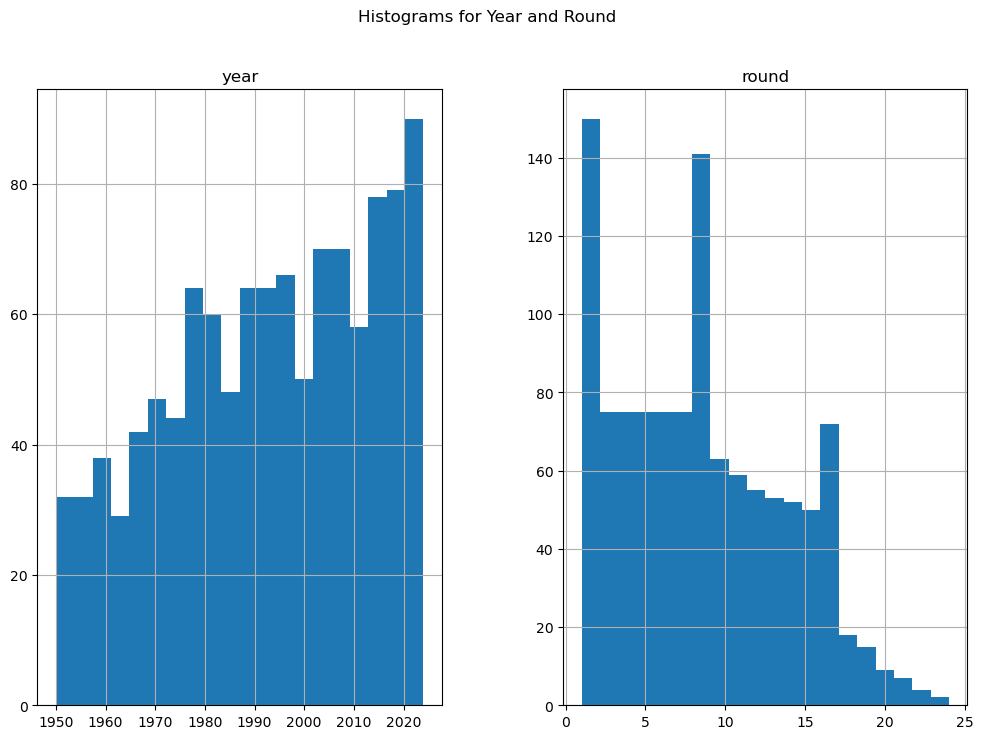

In [20]:
# Plotting histogram for the 'year' column
races[['year', 'round']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms for Year and Round')
plt.show()

In [21]:
# Frequency counts for each categorical column in the results dataset
for column in results.select_dtypes(include=['object']).columns:
    print(f"\nFrequency for {column}:")
    print(results[column].value_counts())


Frequency for number:
number
4      1007
6       994
16      993
8       993
11      989
       ... 
123       1
120       1
126       1
110       1
107       1
Name: count, Length: 130, dtype: int64

Frequency for position:
position
\N    10928
3      1123
4      1123
2      1121
5      1119
1      1116
6      1112
7      1092
8      1064
9      1026
10      966
11      889
12      788
13      701
14      593
15      516
16      422
17      326
18      215
19      135
20       71
21       34
22       19
23        8
24        3
25        1
26        1
27        1
28        1
29        1
30        1
31        1
32        1
33        1
Name: count, dtype: int64

Frequency for positionText:
positionText
R     8876
F     1368
3     1123
4     1123
2     1121
5     1119
1     1116
6     1112
7     1092
8     1064
9     1026
10     966
11     890
12     788
13     701
14     594
15     516
16     422
W      334
17     326
18     215
N      190
D      149
19     135
20      71
21      34
22 

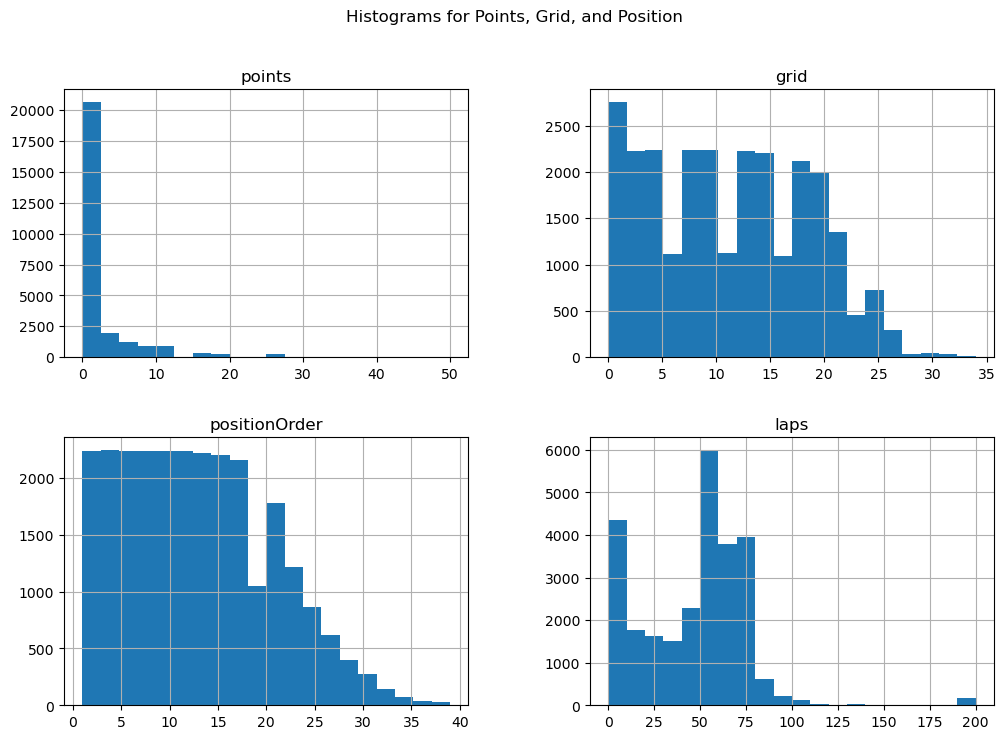

In [22]:
import matplotlib.pyplot as plt

# Plotting histograms for numerical columns in the 'results' dataset
results[['points', 'grid', 'positionOrder','laps']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms for Points, Grid, and Position')
plt.show()

In [23]:
# Frequency counts for each categorical column in the results dataset
for column in status.select_dtypes(include=['object']).columns:
    print(f"\nFrequency for {column}:")
    print(status[column].value_counts())


Frequency for status:
status
Finished          1
Excluded          1
Not restarted     1
Alternator        1
Underweight       1
                 ..
Broken wing       1
Electronics       1
Technical         1
Steering          1
Cooling system    1
Name: count, Length: 139, dtype: int64


In [24]:
# Frequency counts for each categorical column in the results dataset
for column in drivers.select_dtypes(include=['object']).columns:
    print(f"\nFrequency for {column}:")
    print(drivers[column].value_counts())


Frequency for driverRef:
driverRef
hamilton             1
larson               1
shelby               1
orey                 1
fontes               1
                    ..
wilson_fittipaldi    1
tunmer               1
keizan               1
charlton             1
bearman              1
Name: count, Length: 859, dtype: int64

Frequency for number:
number
\N    802
40      2
99      2
21      2
2       2
10      2
22      2
9       2
88      2
28      2
6       2
4       2
18      1
30      1
94      1
53      1
31      1
44      1
16      1
35      1
55      1
63      1
23      1
51      1
89      1
47      1
24      1
81      1
98      1
26      1
12      1
13      1
14      1
7       1
19      1
5       1
8       1
27      1
11      1
33      1
3       1
25      1
77      1
17      1
20      1
45      1
38      1
Name: count, dtype: int64

Frequency for code:
code
\N     757
VER      2
BIA      2
MSC      2
MAG      2
      ... 
MON      1
YAM      1
WIN      1
SPE      1
BEA      1

- Based on the descriptive statistics and analysis of the dataset, the following key insights can be drawn for my hypothesis:
     - The dataset appears to be well-balanced, with a variety of grid positions, race years, and drivers.
     - In the results table, most grid values fall between 5 and 17, with grid = 0 indicating drivers who did not start the race. These rows should be removed from the analysis, as they do not contribute to the race outcome.
     - The average finishing position for drivers is mid-range, but many drivers finish without earning points, which is likely due to race retirements or finishing in positions that do not award points.
     - The dataset spans several decades, covering races from 1950 to 2024, and includes a substantial number of drivers (859 in total). This allows for a comprehensive and robust analysis of race outcomes across different periods and conditions.

#### Merging datasets and then removing rows with grid = 0

In [27]:
# Merge the datasets
merged_data = pd.merge(results, races, on='raceId', how='inner')  # Merge results and races
merged_data = pd.merge(merged_data, drivers, on='driverId', how='inner')  # Merge with drivers
merged_data = pd.merge(merged_data, status, on='statusId', how='inner')  # Merge with status

In [28]:
print(merged_data.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_x',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name',
       'date', 'time_y', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date',
       'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time',
       'sprint_date', 'sprint_time', 'driverRef', 'number_y', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url_y', 'status'],
      dtype='object')


In [29]:
# Count rows where grid = 0 before removal
grid_zero_count_before = merged_data[merged_data['grid'] == 0].shape[0]
print(f"Rows with grid = 0 before removal: {grid_zero_count_before}")

Rows with grid = 0 before removal: 1631


In [30]:
# Remove rows where 'grid' is 0
cleaned_data = merged_data[merged_data['grid'] != 0]

In [31]:
# Count rows where grid = 0 after removal (it should be 0 if removed correctly)
grid_zero_count_after = cleaned_data[cleaned_data['grid'] == 0].shape[0]
print(f"Rows with grid = 0 after removal: {grid_zero_count_after}")

Rows with grid = 0 after removal: 0


-  dodavanje stupca incindent_occured koji ce imati ili vrijednost 0 ako se incident nije dogodio ili vrijednost 1 ako se incident dogodio

In [33]:
incident_statuses = [
    "Accident", "Collision", "Engine", "Gearbox", "Transmission", "Clutch", 
    "Hydraulics", "Electrical", "Spun off", "Radiator", "Suspension", 
    "Brakes", "Differential", "Overheating", "Mechanical", "Tyre", 
    "Driver Seat", "Puncture", "Driveshaft", "Retired", "Fuel pressure", 
    "Front wing", "Water pressure", "Refuelling", "Wheel", "Throttle", 
    "Steering", "Technical", "Electronics", "Broken wing", 
    "Heat shield fire", "Exhaust", "Oil leak", "Wheel rim", "Water leak", 
    "Fuel pump", "Track rod", "Oil pressure", "Engine fire", 
    "Engine misfire", "Tyre puncture", "Out of fuel", "Wheel nut", 
    "Not classified", "Pneumatics", "Handling", "Rear wing", "Fire", 
    "Wheel bearing", "Physical", "Fuel system", "Oil line", 
    "Fuel rig", "Launch control", "Injured", "Fuel", "Power loss", 
    "Vibrations", "Drivetrain", "Ignition", "Chassis", "Battery", 
    "Stalled", "Halfshaft", "Crankshaft", "Safety concerns", 
    "Alternator", "Underweight", "Safety belt", "Oil pump", 
    "Fuel leak", "Excluded", "Injection", "Distributor", "Driver unwell", 
    "Turbo", "CV joint", "Water pump", "Fatal accident", "Spark plugs", 
    "Fuel pipe", "Eye injury", "Oil pipe", "Axle", "Water pipe", 
    "Supercharger", "Collision damage", "Power Unit", "ERS", "Brake duct", 
    "Seat", "Damage", "Debris", "Illness", "Undertray", "Cooling system"
]

# Add 'incident_occurred' column safely
cleaned_data = cleaned_data.copy()  # Ensure it's a standalone copy
cleaned_data.loc[:, 'incident_occurred'] = cleaned_data['status'].apply(lambda x: 1 if x in incident_statuses else 0)

# Display the first few rows to verify
print(cleaned_data[['status', 'incident_occurred']].head())

# Check the count of incidents
print("Count of incidents (1):", cleaned_data['incident_occurred'].sum())
print("Count of non-incidents (0):", len(cleaned_data) - cleaned_data['incident_occurred'].sum())

     status  incident_occurred
0  Finished                  0
1  Finished                  0
2  Finished                  0
3  Finished                  0
4  Finished                  0
Count of incidents (1): 9714
Count of non-incidents (0): 15174


- adding driver skill level to the data (high, medium, low)

In [35]:
print(cleaned_data.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_x',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name',
       'date', 'time_y', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date',
       'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time',
       'sprint_date', 'sprint_time', 'driverRef', 'number_y', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url_y', 'status',
       'incident_occurred'],
      dtype='object')


In [36]:
# Calculate total points per year for each driver
driver_yearly_points = cleaned_data.groupby(['driverId', 'year']).agg(
    yearly_points=('points', 'sum')  # Sum up points for each driver per year
).reset_index()

# Display the result
print(driver_yearly_points.head(20))

    driverId  year  yearly_points
0          1  2007          109.0
1          1  2008           98.0
2          1  2009           49.0
3          1  2010          240.0
4          1  2011          227.0
5          1  2012          190.0
6          1  2013          189.0
7          1  2014          384.0
8          1  2015          381.0
9          1  2016          380.0
10         1  2017          363.0
11         1  2018          408.0
12         1  2019          413.0
13         1  2020          347.0
14         1  2021          385.5
15         1  2022          233.0
16         1  2023          217.0
17         1  2024          100.0
18         2  2000            0.0
19         2  2001           12.0


In [37]:
# Calculate career total points and number of seasons for each driver
driver_performance = driver_yearly_points.groupby('driverId').agg(
    total_points=('yearly_points', 'sum'),  # Total points across all years
    total_seasons=('year', 'nunique')      # Count of unique seasons
).reset_index()

# Display the result
print(driver_performance.head())


   driverId  total_points  total_seasons
0         1        4713.5             18
1         2         259.0             12
2         3        1594.5             11
3         4        2304.0             21
4         5         105.0              7


In [38]:
# Calculate average points per season
driver_performance['avg_points_per_season'] = driver_performance['total_points'] / driver_performance['total_seasons']

# Display the result
print(driver_performance.head())

   driverId  total_points  total_seasons  avg_points_per_season
0         1        4713.5             18             261.861111
1         2         259.0             12              21.583333
2         3        1594.5             11             144.954545
3         4        2304.0             21             109.714286
4         5         105.0              7              15.000000


In [39]:
# Define the thresholds for categorizing the skill level
high_threshold = driver_performance['avg_points_per_season'].quantile(0.9)  # Top 10%
low_threshold = driver_performance['avg_points_per_season'].quantile(0.3)  # Bottom 30%

# Add the driver_skill column based on average points per season
driver_performance['driver_skill'] = driver_performance['avg_points_per_season'].apply(
    lambda x: 'high' if x >= high_threshold else ('low' if x <= low_threshold else 'medium')
)

# Display the result
print(driver_performance.head())

   driverId  total_points  total_seasons  avg_points_per_season driver_skill
0         1        4713.5             18             261.861111         high
1         2         259.0             12              21.583333         high
2         3        1594.5             11             144.954545         high
3         4        2304.0             21             109.714286         high
4         5         105.0              7              15.000000       medium


In [40]:
# Merge the skill level information with the original cleaned_data
cleaned_data = cleaned_data.merge(driver_performance[['driverId', 'driver_skill']], on='driverId', how='left')

# Display the result
print(cleaned_data.head())

   resultId  raceId  driverId  constructorId number_x  grid position  \
0         1      18         1              1       22     1        1   
1         2      18         2              2        3     5        2   
2         3      18         3              3        7     7        3   
3         4      18         4              4        5    11        4   
4         5      18         5              1       23     3        5   

  positionText  positionOrder  points  ...  number_y code  forename  \
0            1              1    10.0  ...        44  HAM     Lewis   
1            2              2     8.0  ...        \N  HEI      Nick   
2            3              3     6.0  ...         6  ROS      Nico   
3            4              4     5.0  ...        14  ALO  Fernando   
4            5              5     4.0  ...        \N  KOV    Heikki   

      surname         dob nationality  \
0    Hamilton  1985-01-07     British   
1    Heidfeld  1977-05-10      German   
2     Rosberg  19

- Adding a grid_category that indicates the likelihood of an incident occurring in that position

In [42]:
# Calculate correlation between grid position and incident occurrence
grid_incident_corr = cleaned_data[['grid', 'incident_occurred']].groupby('grid').mean()

# Display the correlation values (probability of incident for each grid position)
print(grid_incident_corr)

      incident_occurred
grid                   
1              0.247331
2              0.264151
3              0.284436
4              0.314286
5              0.336607
6              0.348607
7              0.341941
8              0.362578
9              0.360714
10             0.400716
11             0.400893
12             0.398206
13             0.408805
14             0.419675
15             0.432334
16             0.415441
17             0.422862
18             0.433109
19             0.430392
20             0.450980
21             0.502152
22             0.495427
23             0.518764
24             0.536131
25             0.548173
26             0.588710
27             0.630435
28             0.533333
29             0.600000
30             0.736842
31             0.444444
32             0.411765
33             0.230769
34             1.000000


In [43]:
# Calculate quantiles for grid position based on incident probability
quantiles = grid_incident_corr['incident_occurred'].quantile([0.2, 0.4, 0.6, 0.8])

# Function to assign grid category based on incident probability
def assign_grid_category(grid_position):
    if grid_position <= quantiles[0.2]:
        return 1
    elif grid_position <= quantiles[0.4]:
        return 2
    elif grid_position <= quantiles[0.6]:
        return 3
    elif grid_position <= quantiles[0.8]:
        return 4
    else:
        return 5

# Add the grid category to the dataframe
cleaned_data['grid_category'] = cleaned_data['grid'].apply(lambda x: assign_grid_category(grid_incident_corr.loc[x, 'incident_occurred']))

# Display the result
print(cleaned_data[['grid', 'grid_category']].head())

   grid  grid_category
0     1              1
1     5              1
2     7              1
3    11              2
4     3              1


In [44]:
print(cleaned_data.head())

   resultId  raceId  driverId  constructorId number_x  grid position  \
0         1      18         1              1       22     1        1   
1         2      18         2              2        3     5        2   
2         3      18         3              3        7     7        3   
3         4      18         4              4        5    11        4   
4         5      18         5              1       23     3        5   

  positionText  positionOrder  points  ...  code  forename     surname  \
0            1              1    10.0  ...   HAM     Lewis    Hamilton   
1            2              2     8.0  ...   HEI      Nick    Heidfeld   
2            3              3     6.0  ...   ROS      Nico     Rosberg   
3            4              4     5.0  ...   ALO  Fernando      Alonso   
4            5              5     4.0  ...   KOV    Heikki  Kovalainen   

          dob nationality                                           url_y  \
0  1985-01-07     British     http://en.wikip